In [2]:
import os
import sys
# Import modules from base directory
sys.path.insert(0, os.getcwd())

import json
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as trfms
from torch.utils.data import Dataset

In [4]:
def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(datset):
        if i == num_samples:
            break
        plt.subplot(num_samples/cols + 1, cols, i + 1)
        plt.imshow(img[0])

data = torchvision.datasets.StanfordCars(root="./data")

index = 0
image = trfms.ToTensor()(data[index][0])
# print(image)
# plt.imshow(image.permute(1, 2, 0))
print(len(data))

8144


In [ ]:

class Cars(Dataset):
    """
    Dataset of car images
    """
    def __init__(self, data_dir="", transform=None):
        super(Cars, self).__init__()

        self.transform = transform
        self.data_dir = data_dir
        self.data = torchvision.datasets.StanfordCars(root=data_dir, split="test", download=True)


    def __getitem__(self, index):
        features = self.feature_list[index]
        input_shape = (256,256)
        hmap_shape = (64,64)

        img_folder_dir = os.path.join(self.data_dir, 'train')
        img_dir = os.path.join(img_folder_dir, features['file'])
        img = mpimg.imread(img_dir)

        # generate crop image
        #print(img)
        img_crop = img
        
        train_img = torch.transpose(img_crop, (2,0,1))/255.0

        return torch.Tensor(train_img)


    def __len__(self):
        return len(self.feature_list)


    def collate_fn(self, batch):
        imgs, heatmaps = list(zip(*batch))

        imgs = torch.stack(imgs, dim=0)
        heatmaps = torch.stack(heatmaps, dim=0)

        return imgs, heatmaps


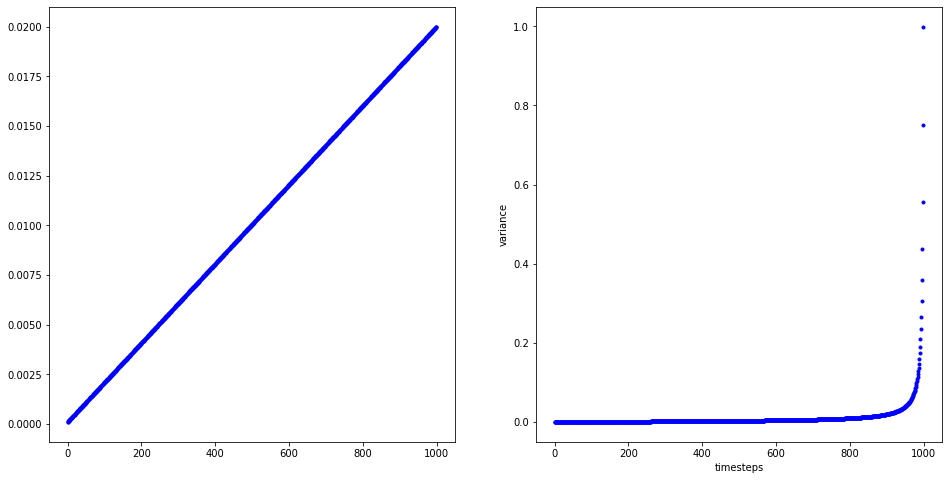

In [15]:
from models.variance_scheduler import linear_beta_schedule, cosine_beta_schedule

num = 1000
timesteps = torch.arange(num)

# find betas
vars = linear_beta_schedule(num)
cos_vars = cosine_beta_schedule(num)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
plt.xlabel(r'timesteps') 
plt.ylabel(r'variance')
axs[0].plot(timesteps, vars, 'b.')
axs[1].plot(timesteps, cos_vars, 'b.')
# plt.title(r'Scatter Plot of $s_{ij}^*$ vs $s_{ij,T}$')
plt.show() 

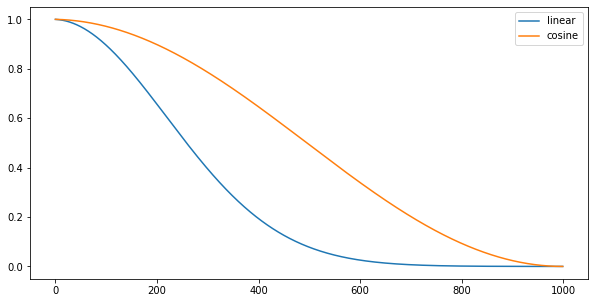

In [16]:
# get cumprods (alpha overline)
cumprods = torch.cumprod(1 - vars, dim=0)
cos_cumprods = torch.cumprod(1 - cos_vars, dim=0)

plt.figure(figsize=(10,5)) 
plt.plot(timesteps, cumprods, label = "linear")
plt.plot(timesteps, cos_cumprods,label = "cosine")
plt.legend()
plt.show()